# Autopilot Blueprint and Trusted AI Guide

This notebook guides you through the process of using a no-code ML pipeline (blueprint) to deliver an optimized ML model. The workflow uses:

 * [Amazon SageMaker DataWrangler](https://aws.amazon.com/sagemaker/data-wrangler/) for data prep. It provdies a graphical interface for creating data prep flows. 
 * [Amazon SageMaker Autopilot](https://aws.amazon.com/sagemaker/autopilot/) for mode creation. It provides AutoML on tabular data through a fully managed experience.
 * [Amazon SageMaker Clarify](https://aws.amazon.com/sagemaker/clarify/) and [Inference](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html) capabilities are used to facilitate Trusted AI.

#### Leaning Objectives

 * Learn how to use the AutoML blueprint.
 * Learn the facilities available to you to facilitated Trusted AI.
 * Deploy a real-time hosted model endpoint that is ready for integration into your analytics systems.
 
#### The Data

This notebook uses the [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) as an example. This tabular dataset contains the results of a marketing campaign to acquire customers for term deposits. Each record represents information about a prospect. The last column is the target variable. It contains information of whether the prospect subscribed to the term deposit. <br><br>_Citation: Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014_

#### Compatibility

* __Amazon SageMaker DataWrangler:__ design and tested for 
  * Flow definition schema: 1.0
  * DataWrangler Processing Container: 1.3.0
  

* __Amazon SageMaker Clarify:__ designed and tested for
  * Bias processing container: 1.0
  * XAI processing container: 1.0
  
* __Amazon SageMaker Studio:__ this notebook was designed and tested on
  * Python3 (Data Science) Kernel
  * Amazon SageMaker SDK version 2.x

You can contact me regarding issues with the blueprint and notebook: <a href="mailto:dylatong@amazon.com">Dylan Tong, AWS</a>

---

## Prerequsites

Follow this [guide](https://github.com/aws-samples/automl-blueprint/blob/main/automl_blueprint_quickstart_guide.pdf) to prepare your environment: https://github.com/aws-samples/automl-blueprint/blob/main/automl_blueprint_quickstart_guide.pdf

The guide provides you step-by-step instructions for satisfying the prerequsites:

1. This notebook requires access to Amazon S3, StepFunctions, and SageMaker. Attach the following managed policies to your Amazon SageMaker Studio execution role:

  * AmazonSageMakerFullAccess
  * AWSStepFunctionsFullAccess
  * AmazonS3FullAccess
  
  
2. Deploy the [Autopilot Blueprint CloudFormation template]( https://dtong-public-fileshares3-us-west-2.amazonaws.com/automl-blueprint/code/cf/automl-blueprint.yml) before you continue further. You can deploy the template from the console by providing the following TemplateURL: https://dtong-public-fileshares3-us-west-2.amazonaws.com/automl-blueprint/code/cf/automl-blueprint.yml. <br> <br> Use the __default settings__ or you will be required to modify the code in this notebook.

 ![Deploy Blueprint Video](img/cf-deploy-bp.gif)

3. Optionally, [clone the Github repository](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-tasks-git.html) over to your Amazon SageMaker Studio instance.

  ![Setup Git Video](img/sm-setup-git.gif)

---

  The blueprint consists of the following assets:

  * __code/deploy:__ the CloudFormation template to deploy the solution.
  * __code/workflow/implementations/autopilot:__ contains the Lambda function code executed as part of a StepFunction workflow. This workflow implemention orchestrates SageMaker DataWrangler, Autopilot, Clarify and other core SageMaker processes. 
  * __code/workflow/layers:__ contains Amazon SageMaker dependencies required by the workflow. These dependencies are deployed as a Lambda Layer.
  * __config/blueprint-config.json:__ this file contains parameters you can configure to change the behavior of the blueprint. The blueprint looks for this configuration file in the S3 bucket that you configured as your workspace. The file should be stored under the prefix /config.
  * __meta/uci-bank-marketing-dataset.flow:__ this is a sample flow file produced by DataWrangler. You can create and save your own flow file in your workspace under the /meta prefix. You will need to reconfigure blueprint-config.json to use your flow file.
  * __notebook:__ this directory contains the assets for this notebook.

___

### Install Dependencies
Run the following to install dependencies that aren't included with the Python 3 (Data Science) Kernel by default.

In [1]:
!conda install -y -c conda-forge tqdm shap

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - shap
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.0               |   py37h89c1867_1         3.1 MB  conda-forge
    openssl-1.1.1k             |       h27cfd23_0         2.5 MB
    shap-0.37.0                |   py37h10a2094_0         510 KB  conda-forge
    slicer-0.0.7               |     pyhd8ed1ab_0          16 KB  conda-forge
    tqdm-4.60.0                |     pyhd8ed1ab_0          79 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         6.2 MB

The following NEW packages will be INSTALLED:

  shap               conda-forge/linux-64::shap-0.37.0-py37h10a2094_0
  slicer             conda-forge/noarch::slicer-0.0.7-pyhd8ed1ab_0

The following packages will be 

### Initialize Notebook

Run the following to assign global variables and import the required libraries.

In [2]:
import json
import os
from time import strftime, gmtime

import numpy as np
import pandas as pd

import boto3

from utils.bpconfig import BPConfig
from utils.trust import ModelInspector
from utils.wf import SFNMonitor,  BPRunner
import utils.wf, utils.bpconfig, utils.prep

sfn = boto3.client("stepfunctions")
sm = boto3.client("sagemaker")
s3 = boto3.client("s3")

account_id = boto3.client('sts').get_caller_identity().get('Account')
region = boto3.session.Session().region_name
workspace = f"bp-workspace-{region}-{account_id}"
bpconfig = BPConfig.get_config(workspace, os.getcwd())
local_dir = os.getcwd()

bprunner = BPRunner(workspace, db_driver=s3, wf_driver=sfn)

inspector_params = {
    "workspace": workspace,
    "drivers":{
        "db": s3,
        "dsmlp": sm
    },
    "prefixes": {
        "results_path": "automl-blueprint/eval/error",
        "bias_path": "automl-blueprint/eval/bias",
        "xai_path": "automl-blueprint/eval/xai"
    },
    "results-config":{
        "gt_index": 0,
        "pred_index": 1,
    }
}

## If you modified the Cloudformation default parameters, you will need to update wf_name accordingly.
WF_NAME = "bp-autopilot-blueprint"
WORKFLOW_STAGES = 9

---

### [Optional] View Pre-training Analysis Reports and Data Flow

This notebook includes a sample flow file for prepping the UCI bank marketing dataset. It includes examples of analysis reports created with Amazon SageMaker DataWrangler for target leakage and data bias analysis.

Run the following cell to download the sample flow.


In [3]:
fname = utils.prep.copy_sample_flow_to_local(workspace, local_dir)
print(f"The flow definition file was copied to {fname}")

The flow definition file was copied to /root/automl-blueprint/notebook/uci-bank-marketing-dataset.flow


---

Launch the DataWrangler GUI from the flow definition file and navigate to the analysis reports as shown below.

![DataWrangler Analysis Reports](img/dw-analysis-reports.gif)



---
The target leakage report should look like the following:


![Target Leakage Report](img/target-leakage-report.png)

---
The data bias analysis report should look like the following:

![Data Bias Report](img/data-bias-report.png)

___

### Run the AutoML Blueprint

By now, the CloudFormation template should be in the COMPLETED status. The template will create a StepFunction workflow which will orchestrate the process of data preparation, model creation using AutoML and model evaluation.


Run the following cell to find the ARN of the blueprint workflow that was created in your account.

In [4]:
wf_arn = bprunner.find_sfn_arn(WF_NAME)
print(f"Found the resource id of your workflow: {wf_arn}")

Found the resource id of your workflow: arn:aws:states:eu-west-1:803235869972:stateMachine:bp-autopilot-blueprint


---
This blueprint is designed to provide a serverless and no-code experience. As you a user, you provide:

1. Raw data
2. An Amazon SageMaker DataWrangler flow created through the GUI
3. Blueprint configurations

Run the cell below to view the default configurations. You don't need to change any of the settings for this tutorial.

In [5]:
config = BPConfig.get_config(workspace, local_dir)
print(f"\n The blueprint configurations were downloaded to {local_dir}/blueprint-config.json \n")
config.print()


 The blueprint configurations were downloaded to /root/automl-blueprint/notebook/blueprint-config.json 

{
    "automl-config": {
        "engine": "sagemaker-autopilot",
        "job_base_name": "automl-bp",
        "max_candidates": "1",
        "metric_name": "AUC",
        "minimum_performance": 0.9,
        "problem_type": "BinaryClassification",
        "target_name": "target"
    },
    "bias-analysis-config": {
        "bias-config": {
            "facet_name": "age",
            "facet_values_or_threshold": [
                30
            ],
            "group_name": "job",
            "label_values_or_threshold": [
                1
            ]
        },
        "engine": "sagemaker-clarify",
        "instance_count": 1,
        "instance_type": "ml.c5.xlarge",
        "job_base_name": "bp-clarify-bias",
        "output_prefix": "eval/bias",
        "prediction-config": {
            "label": null,
            "label_headers": null,
            "probability": 0,
        

___
Run the following cell to execute the blueprint workflow.

In [6]:
execution_arn = bprunner.run_blueprint(WF_NAME, WORKFLOW_STAGES, wait=False)

---

You have the option to monitor the workflow progress from the StepFunctions console, or from this notebook. Run the next cell to obtain the link to the StepFunction workflow console.


In [7]:
from IPython.display import Markdown as md

sfn_console = f"https://{region}.console.aws.amazon.com/states/home?region={region}#/executions/details/{execution_arn}"

md(f"<img src='img/sfn-bp-workflow.png' width=50%, align='right'/> </br> \
   You can monitor the progress of your workflow from the StepFunctions console: </br> </br>\
   {sfn_console}</br></br> \
   Alternatively, you can run the cell below to monitor the progress from your notebook.")

<img src='img/sfn-bp-workflow.png' width=50%, align='right'/> </br>    You can monitor the progress of your workflow from the StepFunctions console: </br> </br>   https://eu-west-1.console.aws.amazon.com/states/home?region=eu-west-1#/executions/details/arn:aws:states:eu-west-1:803235869972:execution:bp-autopilot-blueprint:0700a293-b709-4545-9e0d-8590292bae21</br></br>    Alternatively, you can run the cell below to monitor the progress from your notebook.

---

Run the following cell if you like to render a progress bar to monitor the progress of the workflow.


In [11]:
SFNMonitor().run(execution_arn, WORKFLOW_STAGES)

Workflow Initiated:   0%|          | 0/10 [00:00<?, ?it/s]

>> Parallel Stage: Error Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

>> Parallel Stage: Bias Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

>> Parallel Stage: XAI Analysis:   0%|          | 0/1 [00:00<?, ?it/s]

___

### [Optional] Understand the AutoML Process

This notebook runs the blueprint with Amazon SageMaker Autopilot as the AutoML engine. Autopilot provides transparency into the AutoML process, so you can optionally inspect the automated data profiling and pipeline generation code that gets executed by Autopilot's distributed processing.

The blueprint configurations are set to have Autopilot explore one candidate to minimize the time and cost of this tutorial. However, this isn't practical. In practice, you want Autopilot to explore many candidates resulting in Autopilot to experiment with multiple algorithms and feature processing steps to discover the pipeline that produces the highest performing model on your dataset.

The following steps serve as examples, but won't provide interesting insights. If you like to aim for a production quality type model, you can change the _max_candidates_ configuration to the default value of 250. 

___

Optionally, uncomment and run the following code. This will modify the blueprint configuration file and re-run the blueprint workflow. This will result in a higher quality model and the remainder of the notebook will provide more practical model insights. Regardless, you can proceed through the remainder of the notebook and learn the process and available functionality.

In [ ]:
#Note that you can modify the json configuration file directly, or you could build a GUI for the configuration file.

#MAX_CANDIDATES = 250
#MINIMUM_PERFORMANCE = 0.93

#automl_config = {
#  "job_base_name": "automl-bp",
#  "max_candidates": MAX_CANDIDATES,
#  "target_name": "target",
#  "problem_type": "BinaryClassification",
#  "metric_name": "AUC",
#  "minimum_performance": MINIMUM_PERFORMANCE
#}

#config.update_automl_config(automl_config)
#execution_arn = bprunner.run_blueprint(WF_NAME, WORKFLOW_STAGES, wait=True)

#print(f"StepFunction workflow has completed. The execution Id is: {execution_arn}.")

Workflow Initiated:   0%|          | 0/10 [00:00<?, ?it/s]

---
#### Clear Box AutoML Insights

You can inspect the data profiling and candidate pipeline generation steps from notebooks that were generated as part of your Amazon SageMaker Autopilot job. The following animation shows how you can navigate to these notebooks. 

The candidate generation notebook will only be insightful if you run the blueprint with a sufficiently large max_candidate setting like what is configured in the cell above.

![Autopilot Notebooks](img/autopilot-notebooks.gif)

---

#### Algorithm Performance Analysis

Autopilot generates a leaderboard of results and ranks the training runs (trials) by the objective metric that was configured. In our example, the configuration was AUC.

![Autopilot Leaderboard](img/autopilot-leaderboard.png)

---

Currently, Autopilot doesn't present the performance of competiting algorithms. Some data scientists might desire this information to serve as a performance baseline that the winning model can be evaluated against. 

This information can be obtained, but it requires some manual inspection. The process is as follows. First, open your [Candidate Generation](https://docs.aws.amazon.com/sagemaker/latest/dg/autopilot-automate-model-development-notebook-output.html#candidate-generation-notebook) notebook as demonstrated previously. Inspect, the candidate pipelines as follows and take note of the prefix, which identifies the pipelines:

---
Here's an example of a pipeline that leverages the XGBoost algorithm:

![XGBoost Pipeline](img/xgboost-candidate-pipeline.png)

---
Here's an example of a pipeline that leverages the Linear Learning algorithm (linear and logistic regression):

![Linear Learner Pipeline](img/ll-candidate-pipeline.png)

---
Here's an example of a pipeline that leverages the Multilayer Perceptron (MLP) algorithm (Neural Networks):

![MLP Pipeline](img/mlp-candidate-pipeline.png)

---
This notebook provides you with utility functions to obtain baselines. The metrics returned are the best results for each candidate pipeline. Autopilot runs many training jobs for each candidate pipeline for hyperparameter optimization.

In [12]:
inspector = ModelInspector.get_inspector(inspector_params)

# You will need to replace the list of candidate prefixes with ones specific to your 
# Autopilot job as demonstrated above.
candidate_ids = ["dpp0", "dpp2", "dpp9"]

maximize_objective = True
job_name = bprunner.get_automl_job_name(execution_arn)
baselines = inspector.get_automl_job_baseline(job_name, candidate_ids, maximize_objective)
print(f"Baselines for AutoML Job: {job_name}:\n\n{json.dumps(baselines, indent=3)}")

Baselines for AutoML Job: automl-bp-2021-04-13-23-10-22:

{
   "dpp0": {
      "value": 0.9544699788093567,
      "metric": "validation:auc"
   },
   "dpp2": {
      "value": 0.9394024014472961,
      "metric": "validation:roc_auc_score"
   },
   "dpp9": {
      "value": 0.9437330365180969,
      "metric": "validation:roc_auc"
   }
}


---
Alternatively, you can use the AWS CLI. Set the appropriate candidate prefix. Next, run this cell to obtain the best results for the specified candidate pipeline and the associated AWS CLI command used for this query.

In [13]:
import subprocess
# You will need to set this candidate prefix to one specific to your Autopilot job as demonstrated previously.
candidate_id = 'dpp7'

cmd, results = inspector.get_aws_cli_query_for_baselines(job_name, candidate_id)

print(f"AWS CLI Command:\n\n{cmd}\n")
print(f"Results for automl job: {job_name}\n")
print(json.dumps(results, indent=3))

AWS CLI Command:

aws sagemaker list-candidates-for-auto-ml-job --auto-ml-job-name automl-bp-2021-04-13-23-10-22 --query "max_by(Candidates[].{step_name:CandidateSteps[?CandidateStepType == 'AWS::SageMaker::TrainingJob'].CandidateStepName[?contains(@,'dpp7')==\`true\`],obj_value:FinalAutoMLJobObjectiveMetric.Value}[?not_null(step_name)], &obj_value)"

Results for automl job: automl-bp-2021-04-13-23-10-22

{
   "step_name": [
      "automl-bp--dpp7-1-784f089270d9452a9a4c257578c31169ac79253c178e4"
   ],
   "obj_value": 0.9471700191497803
}


---

### Evaluate your Model

At this point, your workflow should have completed successfully. We can now inspect our model further.

Run the following cell to configure our Model Inspector.

In [14]:
inspector_params = {
    "workspace": workspace,
    "drivers":{
        "db": s3,
        "dsmlp": sm
    },
    "prefixes": {
        "results_path": "automl-blueprint/eval/error",
        "bias_path": "automl-blueprint/eval/bias",
        "xai_path": "automl-blueprint/eval/xai"
    },
    "results-config":{
        "gt_index": 0,
        "pred_index": 1,
    }
}

inspector = ModelInspector.get_inspector(inspector_params)

---

The ModelInspector provides utility functions to create visualizations from the outputs produce by the blueprint workflow. As part of the validation stage, the blueprint batches predictions. In practice, you should set the blueprint configuration to the location of your hold-out test dataset. The blueprint will use this data to generate predictions.<br><br>

"error-analysis-config":{<br>
&emsp;&emsp;...<br>
&emsp;&emsp;"test_data_uri": _"the s3 uri for your test dataset"_<br>
&emsp;&emsp;...<br>
}
<br><br>
For convenience, _test_data_uri_ is set to null in this tutorial. The blueprint will by default use the data used by the automl job. Do not do this in practice.
___

Run the following command to visualize the ROC curve of the best model produced by your blueprint. This gives you a sense of the trade-off between true positive and false positive rates as well as an idea of the overall performance.

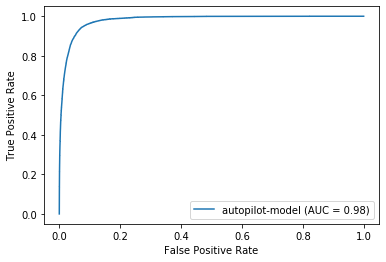

In [15]:
_, _, fpr, tpr, thresholds = inspector.get_roc_curve()

---
Run the following command to visualize the AUC curve to determine an appropriate threshold to you use for your model.


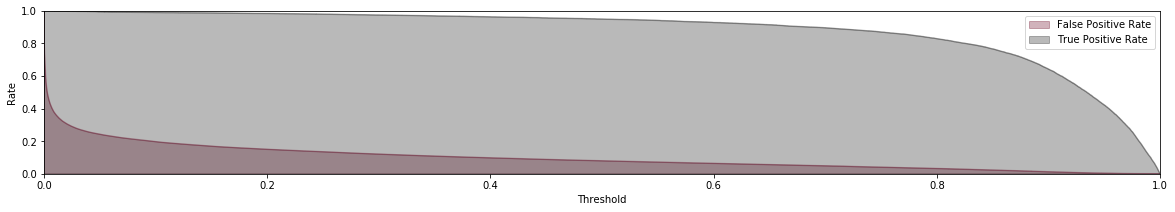

In [16]:
inspector.visualize_auc(fpr,tpr,thresholds)

---
You can also plot a heatmap of the confusion matrix and use the threshold slider to get a sense for the trade-offs at various thresholds.

In [17]:
%matplotlib inline

inspector.display_interactive_cm()

interactive(children=(FloatSlider(value=0.5, description='Threshold', max=1.0, step=0.05), Output()), _dom_cla…

----
#### Global Feature Importance

The blueprint will run an Amazon Clarify job to obtain Shapley values. You can view the global feature importance of your models by navigating to the "Model Explainability" reports as shown below.


![Global Shap Report](img/global-shap-report.gif)

---
The Amazon SageMaker Clarify process produces Shap values for each of records used in your automl job. This notebook provides you with utilities to visualize feature impact of single predictions.

The following utility function will load a sample of your prep dataset for a specific blueprint run. Run the cell to preview your data.

In [9]:
df = bprunner.get_prepped_data_df(execution_arn)
display(df)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7586,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1.0
7587,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0.0
7588,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0.0
7589,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1.0


---
Now, you can use your model inspector to get the feature impact for a specific prediction. The cell below shows the features that influence the prediction for row number 31614. You can change the row id to obtain predictions for other records in your dataset.

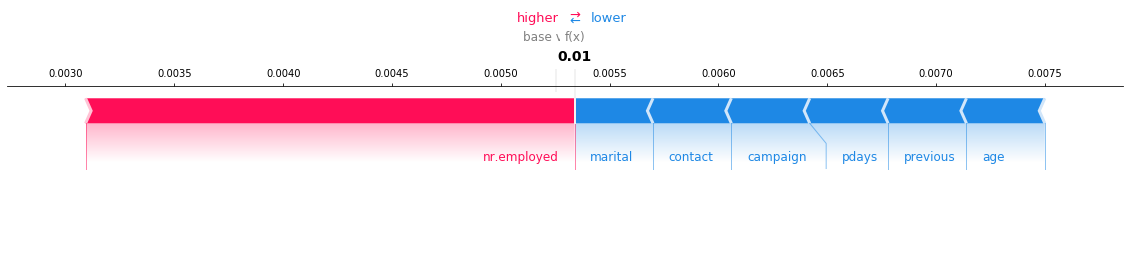

The ground truth was 0.0. The model predicts 0.005339. 



In [18]:
description = inspector.explain_prediction(data_row_id = 31614)
print(description)

---
#### Post Training Bias Analysis

The blueprint uses Amazon SageMaker Clarify to generate post-training bias metrics. The animation below how to navigate to the bias reports generated for your best model.


![Bias Report](img/bp-bias-report.gif)

---
### [Optional] Deploy Model

You've inspected your model. You've approved the quality. You're now ready to deploy as a hosted endpoint on Amazon SageMaker to serve real-time predictions.

You can run the cells below to deploy a hosted endpoint.

In [11]:
now = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

epc_name = f"automl-bp-epc-{now}"
ep_name = f"automl-bp-ep-{now}"

model_name = bprunner.get_best_model_name(execution_arn)
ep_instance_type = "ml.m5.large"

variant_config = {
    "VariantName":"v1",
    "ModelName":model_name,
    "InitialInstanceCount": 1,
    "InstanceType": ep_instance_type
}

sm.create_endpoint_config(
    EndpointConfigName = epc_name,
    ProductionVariants=[variant_config])

sm.create_endpoint(
    EndpointName= ep_name,
    EndpointConfigName=epc_name
)

{'EndpointArn': 'arn:aws:sagemaker:us-west-1:803235869972:endpoint/automl-bp-ep-2021-04-08-21-50-52',
 'ResponseMetadata': {'RequestId': '08a96083-0750-46aa-9f46-066e9b103064',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '08a96083-0750-46aa-9f46-066e9b103064',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '100',
   'date': 'Thu, 08 Apr 2021 21:50:52 GMT'},
  'RetryAttempts': 0}}

You can monitor the progress of your endpoint deployment from Amazon SageMaker Studio:

<img src="img/sm-endpoints.png" width=30% align="left" />

---
#### Clean up

Once you're done with your endpoint, you can uncomment and run this line of code to delete your endpoint.

In [ ]:
#sm.delete_endpoint(EndpointName=ep_name)